In [1]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
train_df = pd.read_csv("../output/0_data_cleaning/lightgbm_2014/train_lightgbm_2014.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})
test_df = pd.read_csv("../output/0_data_cleaning/lightgbm_2014/test_lightgbm_2014.csv").rename(columns={'country_index': 'country', 'co2_including_luc': 'co2'})

In [3]:
train_df

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,coal_co2_lag_1,flaring_co2_lag_1,gas_co2_lag_1,land_use_change_co2_lag_1,oil_co2_lag_1,co2
0,1929,Argentina,0.006761,0.004880,0.018519,0.000162,0.001110,0.000000,0.000216,0.145501,0.001529,0.042267
1,1930,Argentina,0.006968,0.004673,0.018519,0.000243,0.001115,0.000000,0.000334,0.145747,0.001581,0.037537
2,1931,Argentina,0.007159,0.004340,0.018519,0.000264,0.001088,0.000000,0.000331,0.130852,0.001516,0.034449
3,1932,Argentina,0.007333,0.004193,0.018519,0.000371,0.000931,0.000000,0.000411,0.121032,0.001917,0.032754
4,1933,Argentina,0.007490,0.004394,0.018519,0.000346,0.000848,0.000000,0.000560,0.115574,0.002177,0.031597
...,...,...,...,...,...,...,...,...,...,...,...,...
3544,2009,Vietnam,0.061378,0.024047,0.018519,0.021493,0.005846,0.012981,0.010131,0.107045,0.015295,0.048437
3545,2010,Vietnam,0.062053,0.025535,0.018519,0.026916,0.006094,0.013979,0.011205,0.130652,0.016400,0.044151
3546,2011,Vietnam,0.062736,0.027067,0.018519,0.033255,0.006358,0.013021,0.013155,0.112360,0.018656,0.043697
3547,2012,Vietnam,0.063429,0.028564,0.023148,0.039485,0.007977,0.017730,0.011865,0.106872,0.017852,0.042866


In [11]:
test_df

,year,country,population,gdp,temperature_change_from_co2,cement_co2_lag_1,coal_co2_lag_1,flaring_co2_lag_1,gas_co2_lag_1,land_use_change_co2_lag_1,oil_co2_lag_1,co2
0,2014,Argentina,0.029601,0.051222,0.046296,0.006409,0.000648,0.017171,0.066569,0.111846,0.033105,0.046557
1,2015,Argentina,0.029917,0.052624,0.050926,0.006066,0.000742,0.018461,0.067667,0.104790,0.031896,0.046434
2,2016,Argentina,0.030216,0.051527,0.050926,0.006395,0.000732,0.016200,0.068171,0.103356,0.032904,0.044811
3,2017,Argentina,0.030497,0.052983,0.050926,0.005637,0.000562,0.011186,0.070188,0.098775,0.031996,0.043281
4,2018,Argentina,0.030758,0.051593,0.050926,0.006103,0.000573,0.012769,0.070289,0.094860,0.030596,0.041428
...,...,...,...,...,...,...,...,...,...,...,...,...
400,2018,Vietnam,0.067514,0.042150,0.023148,0.059787,0.014498,0.023050,0.013029,0.153375,0.022354,0.067964
401,2019,Vietnam,0.068142,0.045261,0.027778,0.069444,0.016360,0.018262,0.013523,0.151128,0.024988,0.076314
402,2020,Vietnam,0.068777,0.046562,0.027778,0.079098,0.025646,0.019326,0.013779,0.151447,0.027793,0.078594
403,2021,Vietnam,0.069373,0.047758,0.027778,0.084034,0.028911,0.016719,0.012340,0.151971,0.026213,0.077848


In [4]:
# Ensure that 'country' is treated as a string
train_df['country'] = train_df['country'].astype(str)
test_df['country'] = test_df['country'].astype(str)

# Set up the lags
max_lag = 1  # Adjust as necessary
lags = list(range(1, max_lag + 1))

# List of dynamic features (excluding 'co2', 'year', and 'country')
dynamic_features = train_df.columns.drop(['co2', 'year', 'country']).tolist()

In [5]:
# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    param = {
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        # 'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        # "max_depth": trial.suggest_int("max_depth", 3, 10),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        # 'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        # 'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        # 'lambda_l2': trial.suggest_float('lambda_l2', 1.0, 10.0),
        # 'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.1, 0.2),
        # 'random_state': 42,
        # 'objective': 'regression',
        # 'verbosity': 0,
        # 'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'random_state': 0, 
        'verbosity': -1
    }

    # Initialize the model
    model = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model = MLForecast(
        models=[model],
        freq=1,
        lags=lags,
        date_features=None,
        num_threads=-1
    )

    # Fit the model
    forecast_model.fit(
        train_df,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Perform cross-validation
    cv_predictions = forecast_model.cross_validation(
        df=train_df,
        h=5,
        n_windows=3,
        #step_size=1,
        id_col='country',
        time_col='year',
        target_col='co2',
        static_features=[]
    )

    # Rename 'LGBMRegressor' to 'co2_predicted'
    cv_predictions = cv_predictions.rename(columns={'LGBMRegressor': 'co2_predicted'})

    # Merge predictions with actual values
    results_train = cv_predictions.merge(
        train_df[['country', 'year', 'co2']],
        on=['country', 'year', 'co2'],
        how='left'
    )

    # Rename 'co2' to 'co2_actual'
    results_train = results_train.rename(columns={'co2': 'co2_actual'})

    # Drop any rows with NaNs
    results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])

    return mape

In [6]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-11-14 22:00:53,407] A new study created in memory with name: no-name-d70d2095-f3f9-42cc-9c06-acfbb6ddd1cd
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")
[I 2024-11-14 22:00:53,710] Trial 0 finished with value: 0.10548975067404336 and parameters: {'learning_rate': 0.05399000549470679, 'max_depth': 2, 'num_leaves': 35}. Best is trial 0 with value: 0.10548975067404336.
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")
[I 2024-11-14 22:00:54,095] Trial 1 finished with value: 0.10240561342734214 and parameters: {'learning_rate': 0.09659649506371266, 'max_depth': 3, 'num_leaves': 48}. Best is trial 1 with value: 0.10240561342734214.
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings

Best Hyperparameters: {'learning_rate': 0.07945658495583656, 'max_depth': 2, 'num_leaves': 15}


In [7]:
best_params

{'learning_rate': 0.07945658495583656, 'max_depth': 2, 'num_leaves': 15}

In [8]:
# Initialize the model with best hyperparameters
best_model = LGBMRegressor(
    **best_params,
    #objective='regression',
    #random_state=42,
    verbosity=-1,
    random_state = 0,
    #n_jobs=-1
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    lags=lags,
    date_features=None,
    num_threads=-1
)

# Fit the model on the entire training data
forecast_model.fit(
    train_df,
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/mlforecast/core.py:185: UserWarning: Setting num_threads to 1.
  warnings.warn("Setting num_threads to 1.")


MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag1'], date_features=[], num_threads=1)

In [9]:
#TRAIN DATA
# Get the fitted values on the training data
fitted_values = forecast_model.forecast_fitted_values()

# Rename 'LGBMRegressor' to 'co2_predicted'
fitted_values = fitted_values.rename(columns={'LGBMRegressor': 'co2_predicted'})

# Merge fitted values with actual values
results_train = fitted_values.merge(
    train_df[['country', 'year', 'co2']],
    on=['country', 'year', 'co2'],
    how='left'
)

# Rename 'co2' to 'co2_actual'
results_train = results_train.rename(columns={'co2': 'co2_actual'})

# Drop any rows with NaNs
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

# Calculate the Mean Absolute Percentage Error (MAPE) on the training set
train_mape = mean_absolute_percentage_error(results_train['co2_actual'], results_train['co2_predicted'])
print(f"Train MAPE: {train_mape}")

Train MAPE: 29624383066.929684


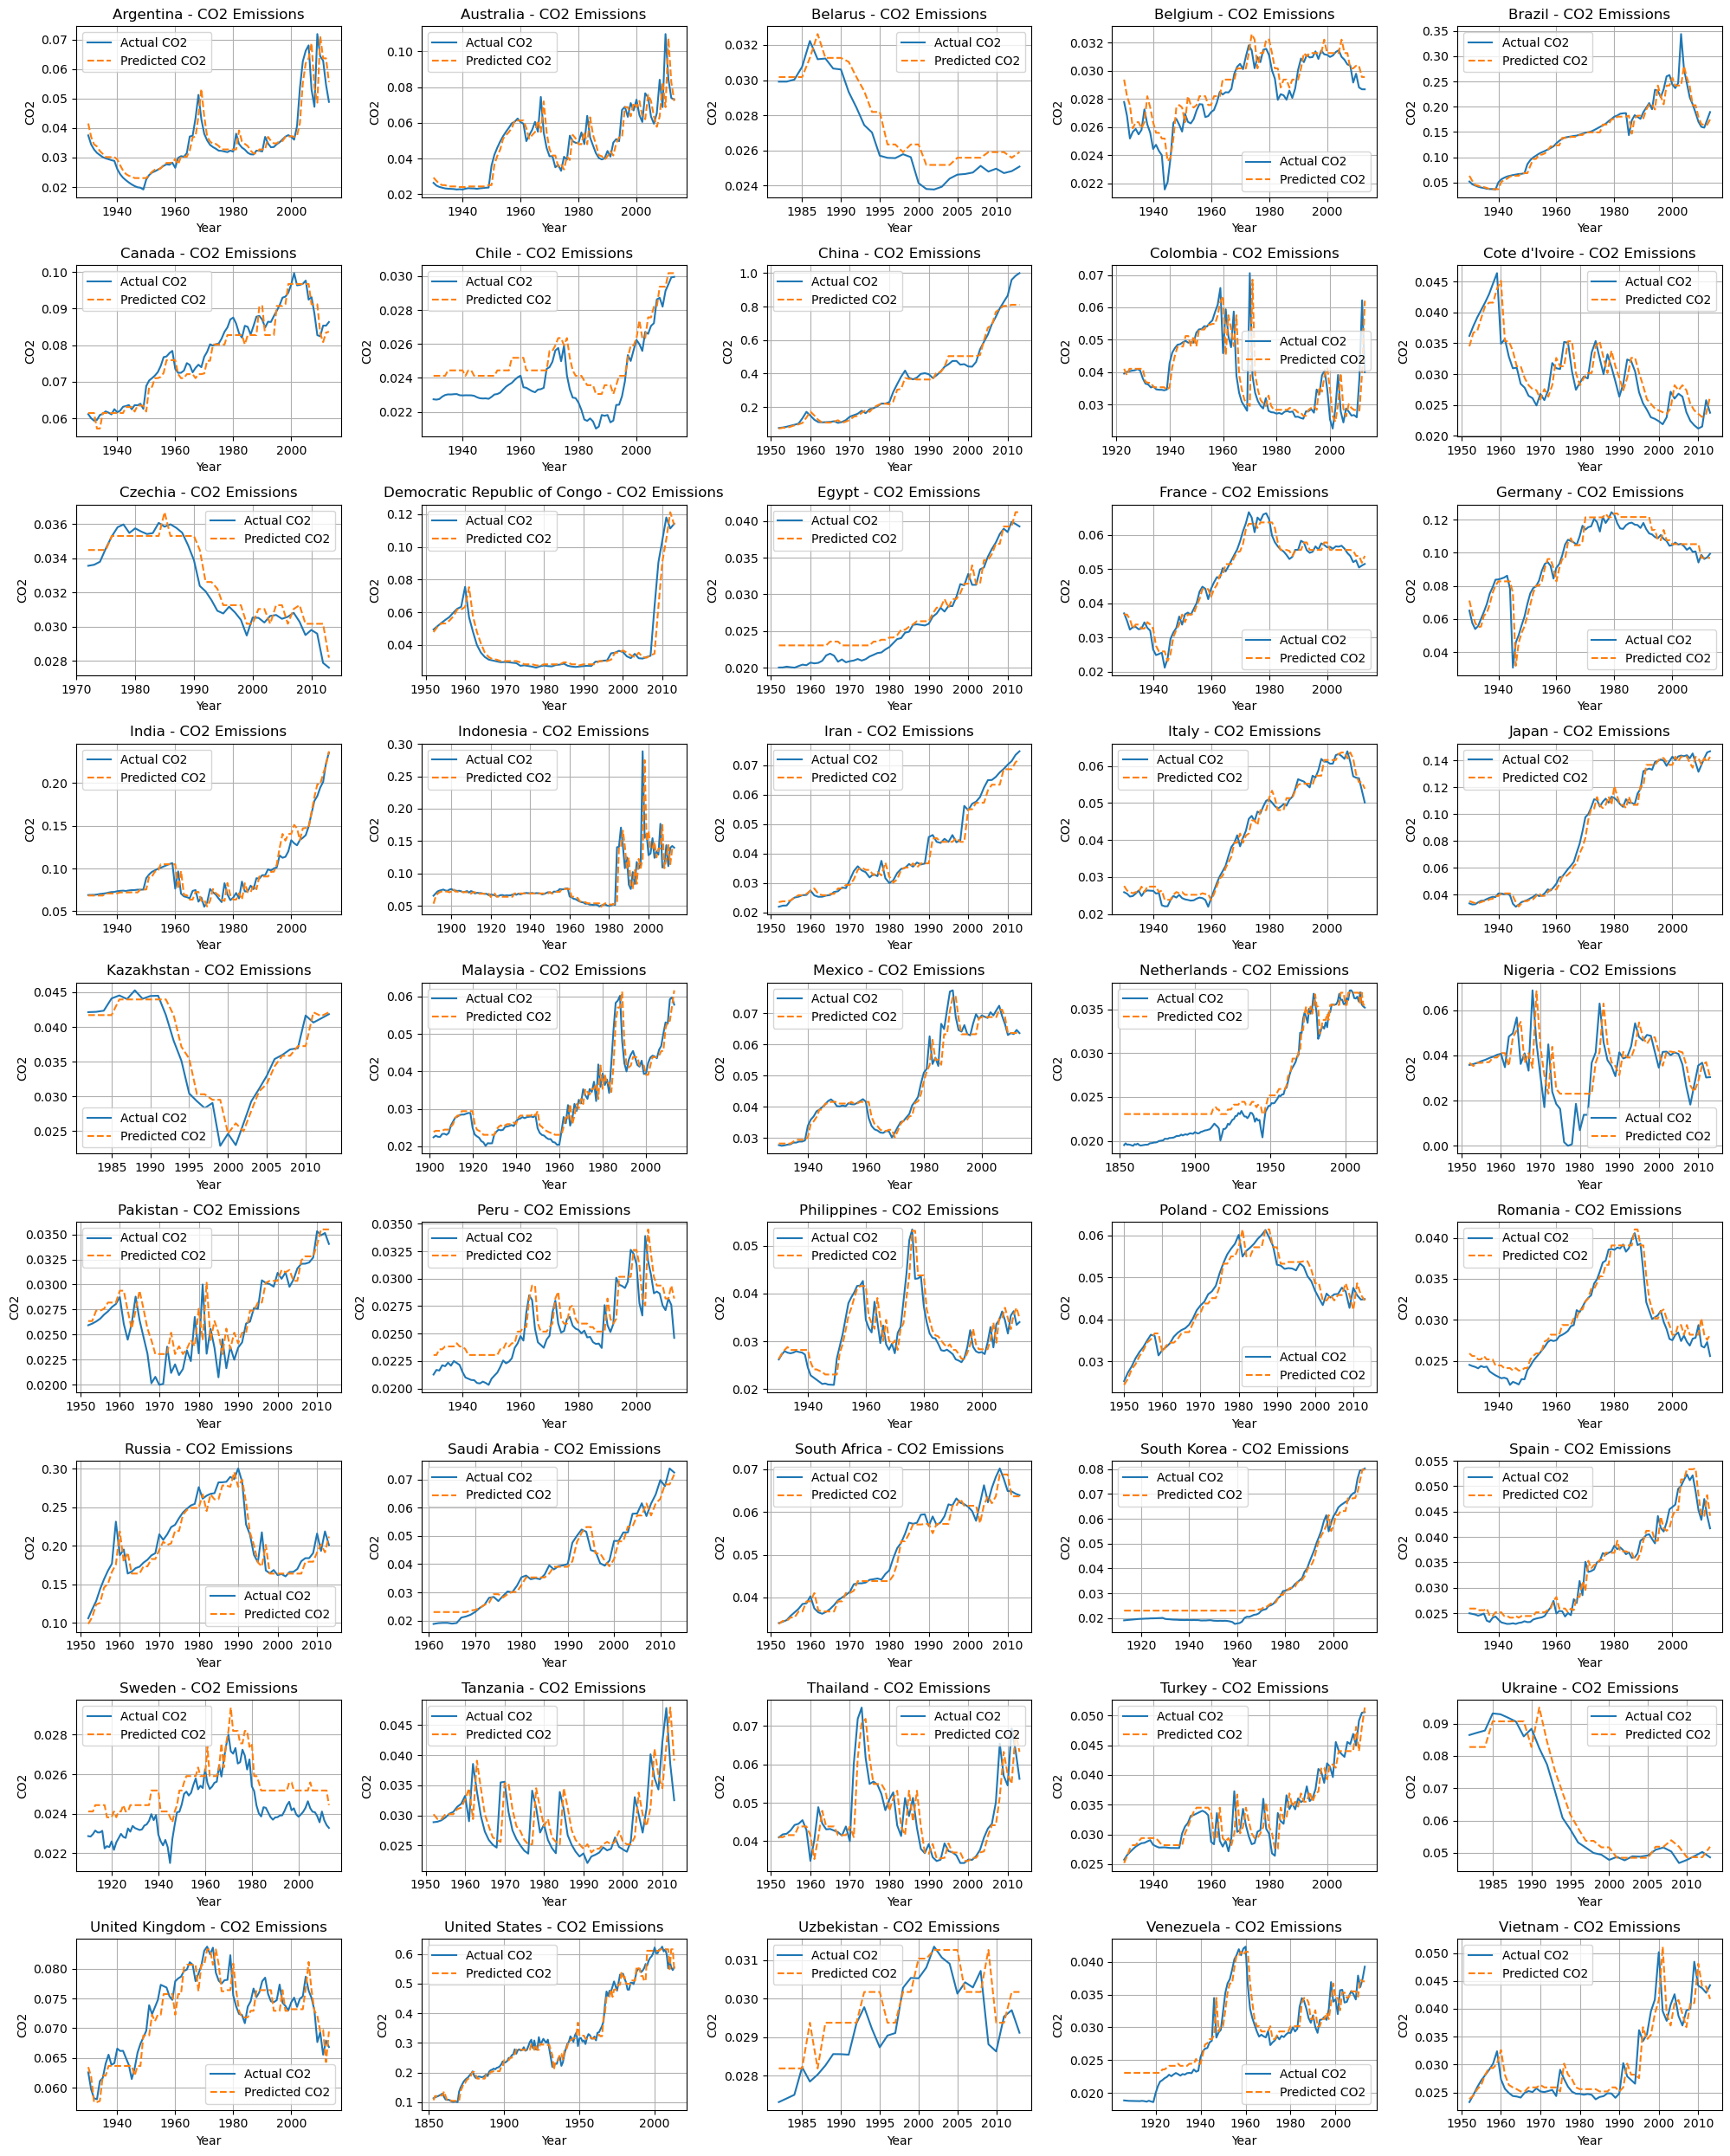

In [10]:
#TRAIN DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_train['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_train[results_train['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [77]:
# TEST DATA
# Initialize an empty list to collect predictions
all_predictions = []

# Loop over each country in the test set
for country in test_df['country'].unique():
    # Select test data specific to this country
    country_test_data = test_df[test_df['country'] == country].copy()
    
    # Set the horizon to the number of years to predict for this country
    horizon = country_test_data['year'].nunique()
    
    # Drop the target column from the country-specific test data to avoid leakage
    country_test_features = country_test_data.drop(columns=['co2'])

    # Predict using the exact test data for this country
    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids = [country])
    
    # Add country identifier to the predictions for merging later
    country_predictions['country'] = country
    
    # Append to the list of all predictions
    all_predictions.append(country_predictions)

# Concatenate all country-specific predictions
predictions_df = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2'})

# Merge predictions with actual train values for comparison
results_test = predictions_df.merge(
    test_df[['country', 'year', 'co2']],
    on=['country', 'year'],
    how='left',
    suffixes=('_predicted', '_actual')
)

# # Display the first few rows of the predictions vs actuals
print(results_test)

# # Calculate the Mean Absolute Percentage Error (MAPE) on the train set
mape = mean_absolute_percentage_error(results_test['co2_actual'], results_test['co2_predicted'])
print(f"Test MAPE: {mape}")

       country  year  co2_predicted  co2_actual
0    Argentina  2004       0.075889    0.084815
1    Argentina  2005       0.078793    0.089670
2    Argentina  2006       0.081852    0.092114
3    Argentina  2007       0.085592    0.071866
4    Argentina  2008       0.087841    0.063909
..         ...   ...            ...         ...
805    Vietnam  2018       0.064069    0.091968
806    Vietnam  2019       0.059884    0.103267
807    Vietnam  2020       0.056821    0.106353
808    Vietnam  2021       0.054007    0.105343
809    Vietnam  2022       0.053333    0.103998

[810 rows x 4 columns]
Test MAPE: 0.25053191530899


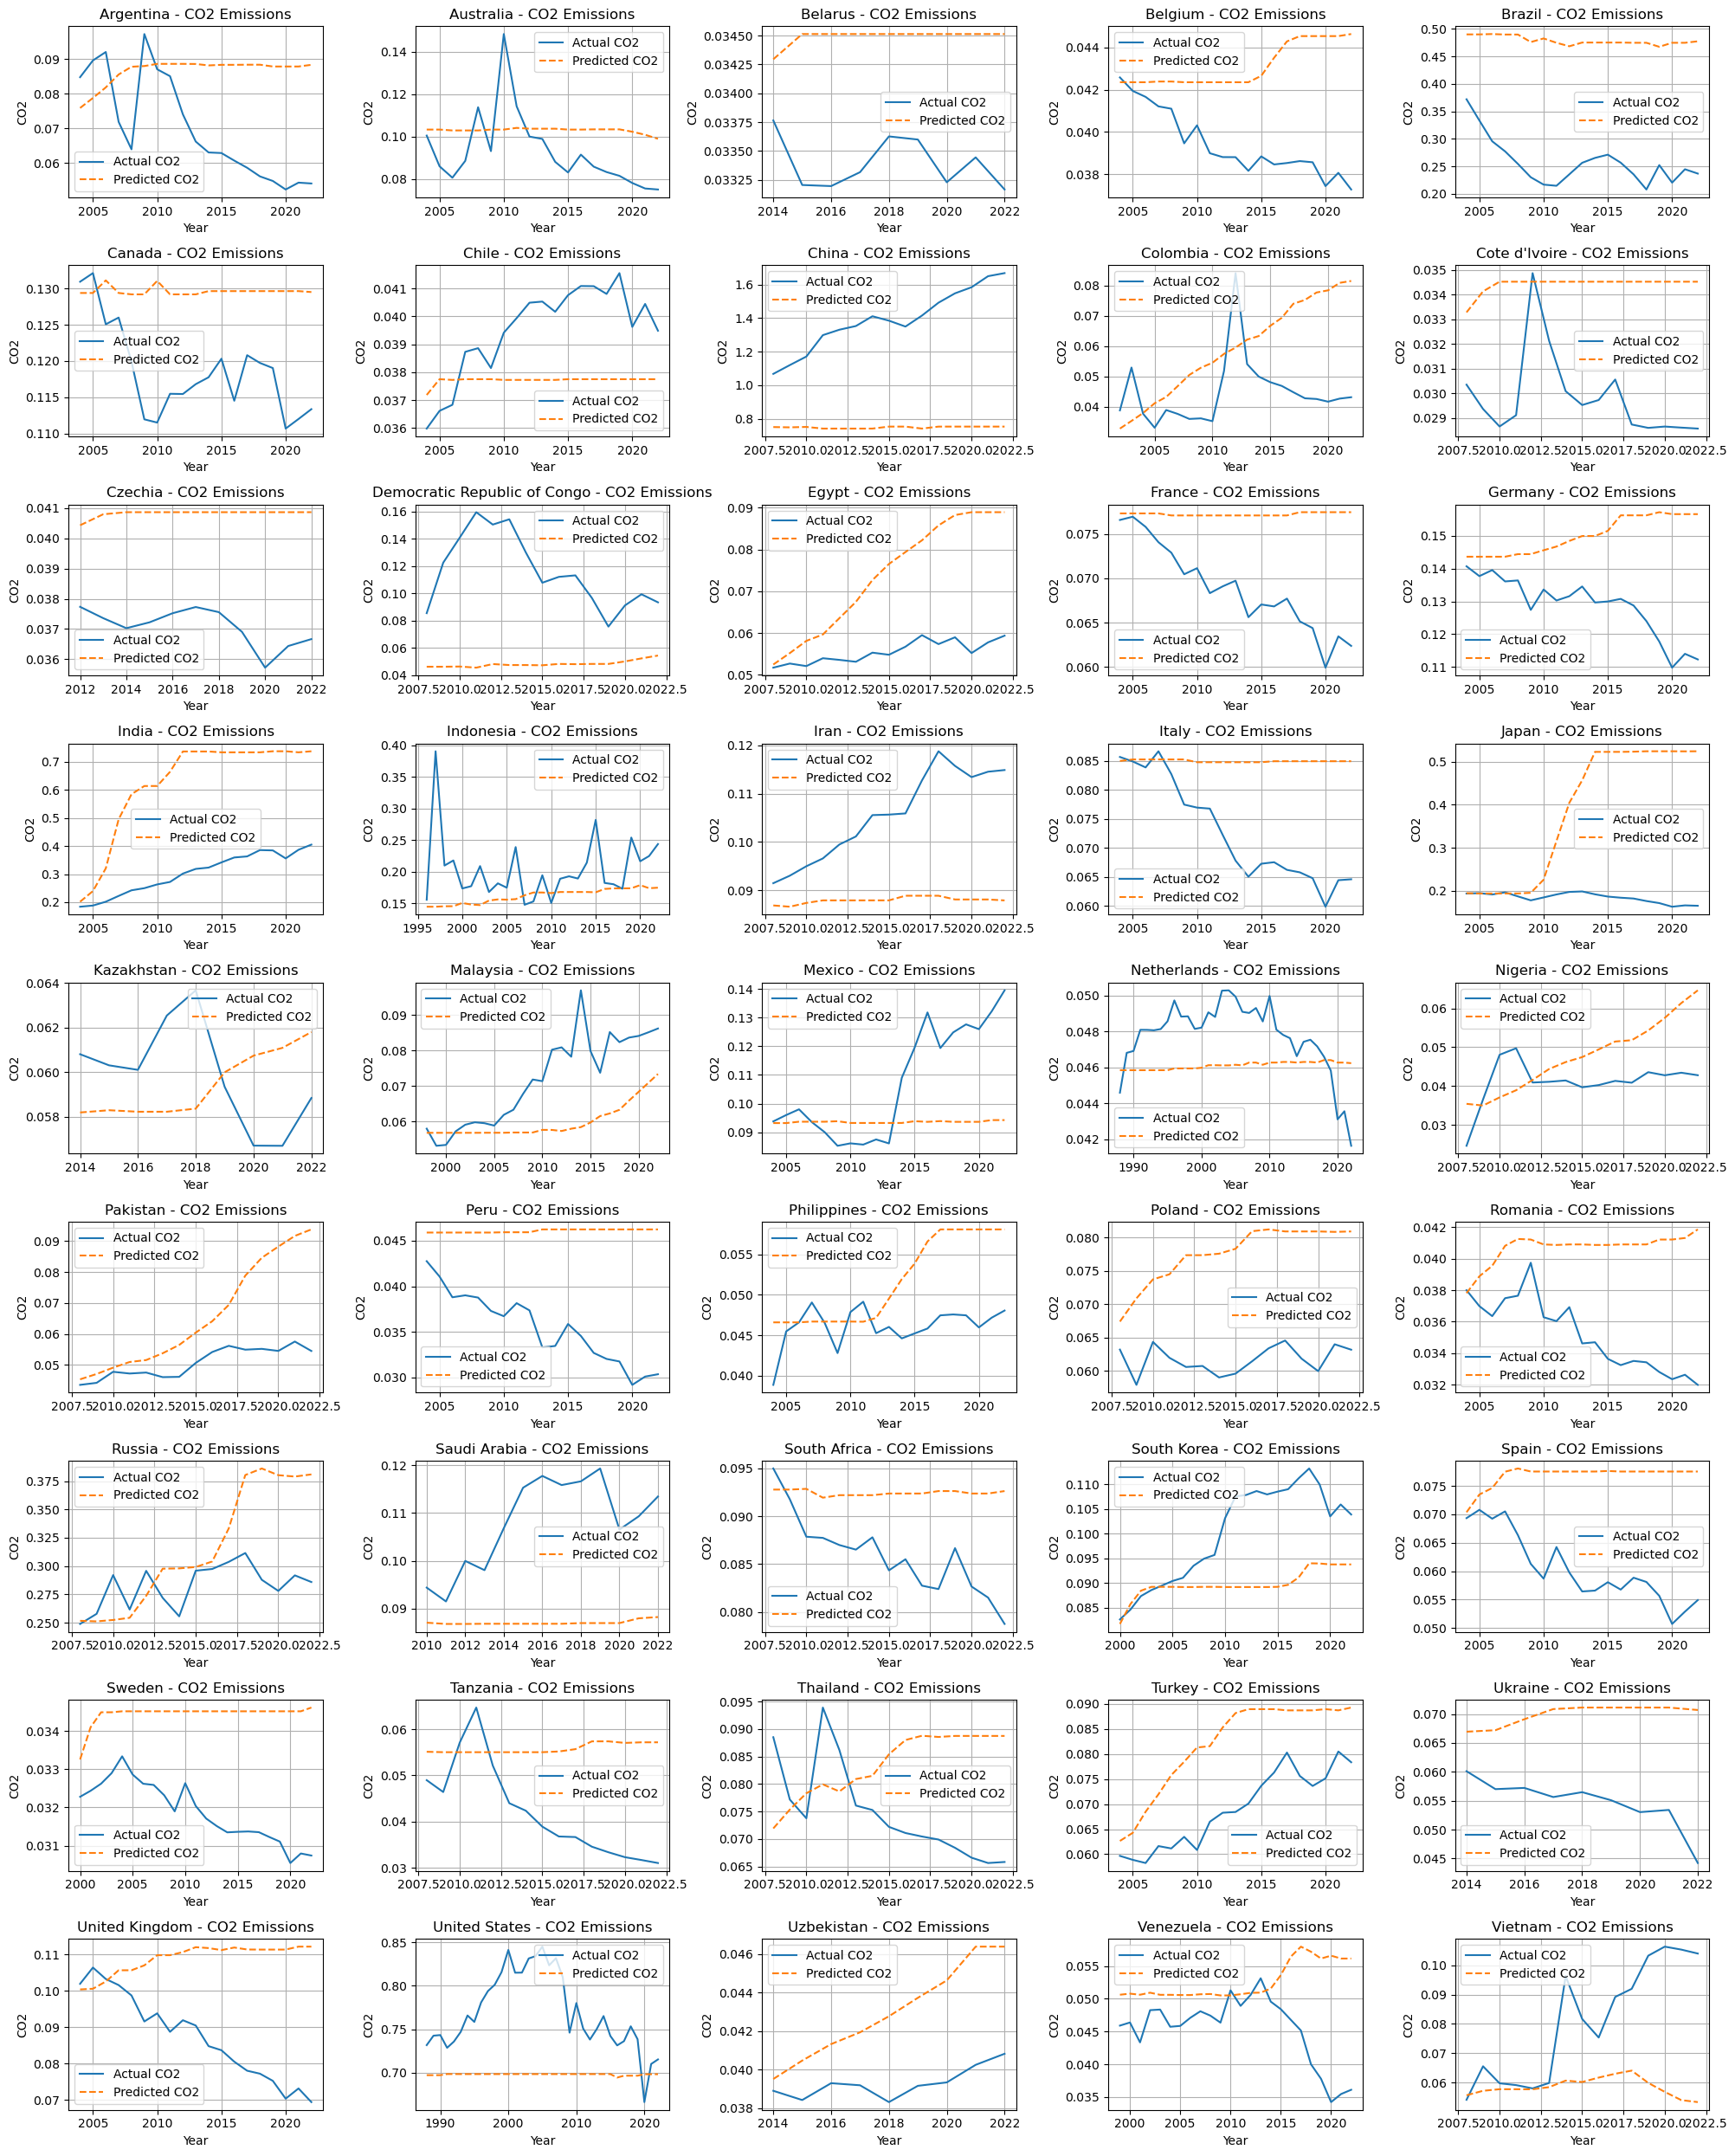

In [78]:
#TEST DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_test['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_test[results_test['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
#TEST DATA
# Set the prediction horizon to 9 years (from 2014 to 2022)
horizon = 9

# Prepare the test features by removing the target column to avoid leakage
test_features = test_df.drop(columns=['co2'])

# Make predictions for all countries at once over the 9-year horizon
predictions_df = forecast_model.predict(h=horizon, X_df=test_features)

# Rename the predicted column for clarity
predictions_df = predictions_df.rename(columns={'LGBMRegressor': 'co2_predicted'})

# Merge predictions with actual values from the test set for comparison
results_test = predictions_df.merge(
    test_df[['country', 'year', 'co2']],
    on=['country', 'year'],
    how='left'
).rename(columns={'co2': 'co2_actual'})

# Display the first few rows of the predictions vs actuals
print(results_test)

# Calculate the Mean Absolute Percentage Error (MAPE) for the test set
mape = mean_absolute_percentage_error(results_test['co2_actual'], results_test['co2_predicted'])
print(f"Test MAPE: {mape}")

       country  year  co2_predicted  co2_actual
0    Argentina  2014       0.048633    0.046557
1    Argentina  2015       0.048633    0.046434
2    Argentina  2016       0.048633    0.044811
3    Argentina  2017       0.048633    0.043281
4    Argentina  2018       0.048633    0.041428
..         ...   ...            ...         ...
400    Vietnam  2018       0.044005    0.067964
401    Vietnam  2019       0.038953    0.076314
402    Vietnam  2020       0.034208    0.078594
403    Vietnam  2021       0.029624    0.077848
404    Vietnam  2022       0.025306    0.076854

[405 rows x 4 columns]
Test MAPE: 0.170035376346913


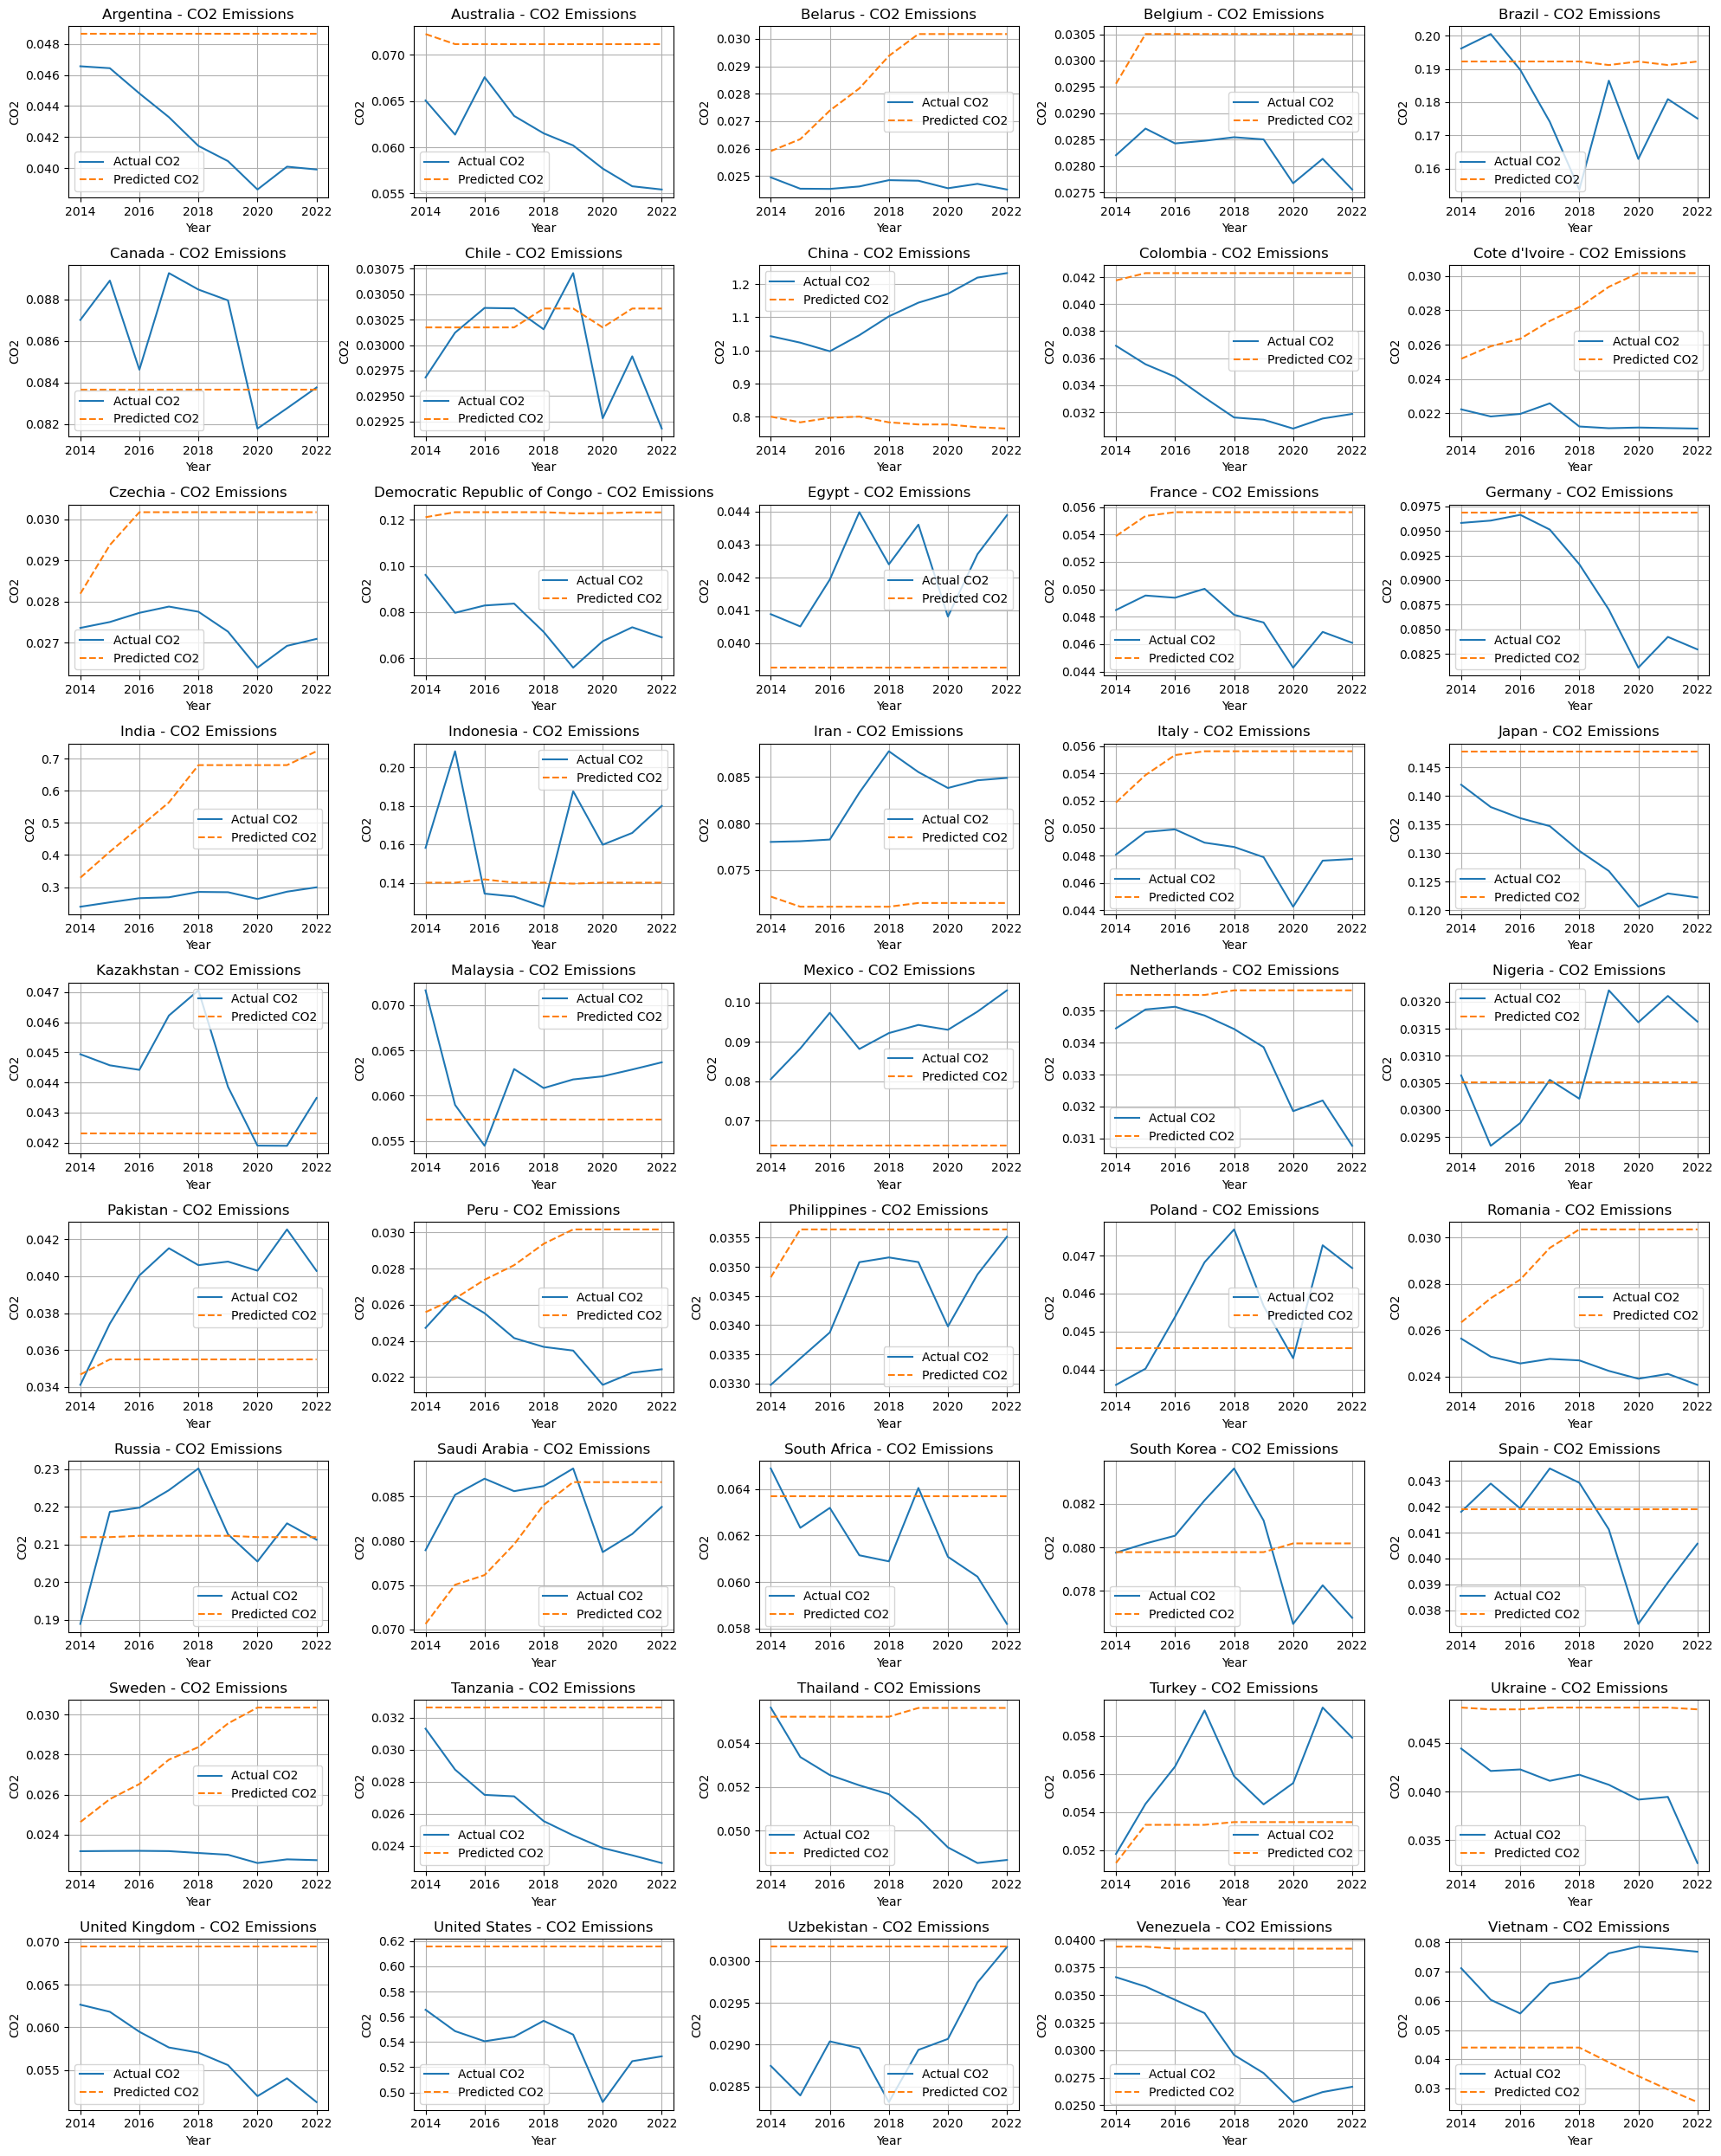

In [13]:
#TEST DATA
# Define the layout for subplots
num_rows = 9
num_cols = 5
countries = results_test['country'].unique()  # Get unique countries

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25), squeeze=False)
axes = axes.flatten()

for i, country in enumerate(countries):
    # Filter results for the current country
    country_results = results_test[results_test['country'] == country]
    ax = axes[i]
    
    # Plot the actual and predicted CO2 for each country
    ax.plot(country_results['year'], country_results['co2_actual'], label='Actual CO2')
    ax.plot(country_results['year'], country_results['co2_predicted'], label='Predicted CO2', linestyle='--')
    
    ax.set_title(f'{country} - CO2 Emissions')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2')
    ax.grid(True)
    
    ax.legend()

# Delete any remaining unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()